# Regular Gasoline Price Forecast - Time Series

## Data Set Info:
This [data set](https://catalog.data.gov/dataset/short-term-energy-outlook-real-and-nominal-petroleum-prices) was scraped from the Department of Energy, which provides annual, quarterly, and monthly prices back to 1976 for gasoline , heating oil, and diesel fuel. Also provides annual prices from 1968 and quarterly and monthly prices from 1974 for imported crude oil. Based on Form EIA-878 data.

### Goal:
Try to predict the monthly average real price of regular Gasoline ($/gallon) of future dates. 

### Data Attributes

- Month: the time periods are periodically seperated per month from 1976 to February 2023
- CPI(1982-84 =1): Consumer Price Index is a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services.
- Nominal: The price paid for a product or service at the time of the transaction.
- Motor Gasoline Price($/gallon): The relative or real price is its value in terms of some other good, service, or bundle of goods

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# setting our seaborn color palette
color_pal = sns.color_palette() 
plt.style.use('fivethirtyeight')

In [2]:
# Load the data
gas = pd.read_csv('Gasoline.csv')
# dataframe shape
gas.shape

(568, 5)

In [3]:
# first 5 observations
gas.head()

,Month,Index (1982-84=1),Nominal,Motor Gasoline Price($/gallon),Base CPI (5/2023)
0,January 1976,0.558,0.61,3.29,3.034943
1,February 1976,0.559,0.60,3.26,NaN
2,March 1976,0.560,0.59,3.22,NaN
3,April 1976,0.561,0.59,3.20,NaN
4,May 1976,0.564,0.60,3.23,NaN


Definition: The nominal price of a good is its value in terms of money, such as dollars, French francs, or yen. The relative or real price is its value in terms of some other good, service, or bundle of goods. The term “relative price” is used to make comparisons of different goods at the same moment of time. The term “real price” tends to be used to make comparisons of one good to a group or bundle of other goods across different time periods, such as one year to the next.

In [4]:
# create a dataframe copy to work with
df = gas.copy()

In [5]:
# dataframe columns
df.columns

Index(['Month', 'Index (1982-84=1)', 'Nominal',
       'Motor Gasoline Price($/gallon)', 'Base CPI (5/2023)'],
      dtype='object')

In [6]:
# rename the columns of the dataframe
df.rename(columns = {'Month':'Datetime',
                     'Motor Gasoline Price($/gallon)':'Gas Price',
                     'Index (1982-84=1)':'CPI',
                     'Base CPI (5/2023)':'Base CPI'
                    },
          inplace = True)

In [7]:
# check column names
df.columns

Index(['Datetime', 'CPI', 'Nominal', 'Gas Price', 'Base CPI'], dtype='object')

In [8]:
df.drop('Base CPI', axis = 1, inplace = True)

In [9]:
# first 5 rows
df.head()

,Datetime,CPI,Nominal,Gas Price
0,January 1976,0.558,0.61,3.29
1,February 1976,0.559,0.60,3.26
2,March 1976,0.560,0.59,3.22
3,April 1976,0.561,0.59,3.20
4,May 1976,0.564,0.60,3.23


In [10]:
# Set the Datetime as our index
df = df.set_index('Datetime')
df.head()

,CPI,Nominal,Gas Price
Datetime,,,
January 1976,0.558,0.61,3.29
February 1976,0.559,0.60,3.26
March 1976,0.560,0.59,3.22
April 1976,0.561,0.59,3.20
May 1976,0.564,0.60,3.23


In [11]:
# check the data type of our index
df.index

Index(['January 1976', 'February 1976', 'March 1976', 'April 1976', 'May 1976',
       'June 1976', 'July 1976', 'August 1976', 'September 1976',
       'October 1976',
       ...
       'July 2022', 'August 2022', 'September 2022', 'October 2022',
       'November 2022', 'December 2022', 'January 2023', 'February 2023',
       'March 2023', 'April 2023'],
      dtype='object', name='Datetime', length=568)

In [12]:
# make the index from object to datetime data type
# makes our plot look cleaner
df.index = pd.to_datetime(df.index)

In [13]:
# check the index 
df.head()

,CPI,Nominal,Gas Price
Datetime,,,
1976-01-01,0.558,0.61,3.29
1976-02-01,0.559,0.60,3.26
1976-03-01,0.560,0.59,3.22
1976-04-01,0.561,0.59,3.20
1976-05-01,0.564,0.60,3.23


In [14]:
# print the last 5 rows
df.tail()

,CPI,Nominal,Gas Price
Datetime,,,
2022-12-01,2.990,3.21,3.26
2023-01-01,3.005,3.34,3.37
2023-02-01,3.016,3.39,3.41
2023-03-01,3.018,3.42,3.44
2023-04-01,3.028,3.60,3.61


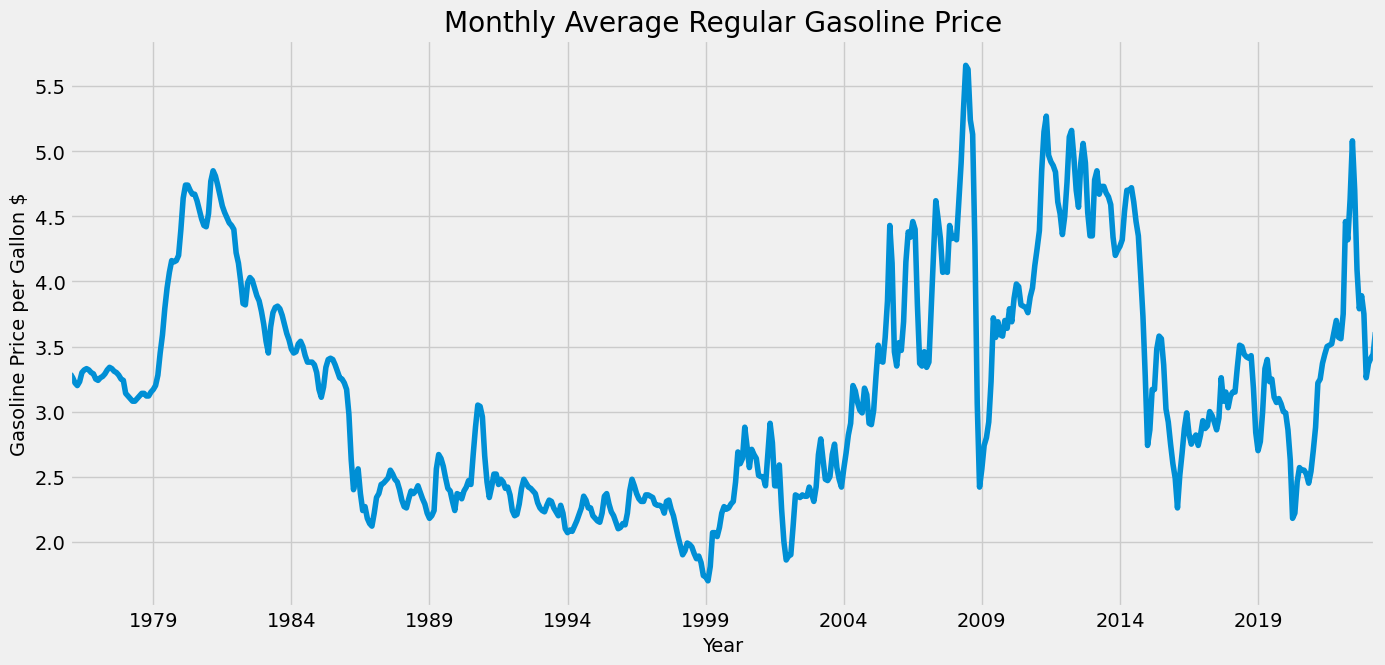

In [15]:
# plot the Gasoline Price
df['Gas Price'].plot(figsize = (15,7))
plt.title("Monthly Average Regular Gasoline Price")
plt.ylabel("Gasoline Price per Gallon $")
plt.xlabel("Year")
plt.show()

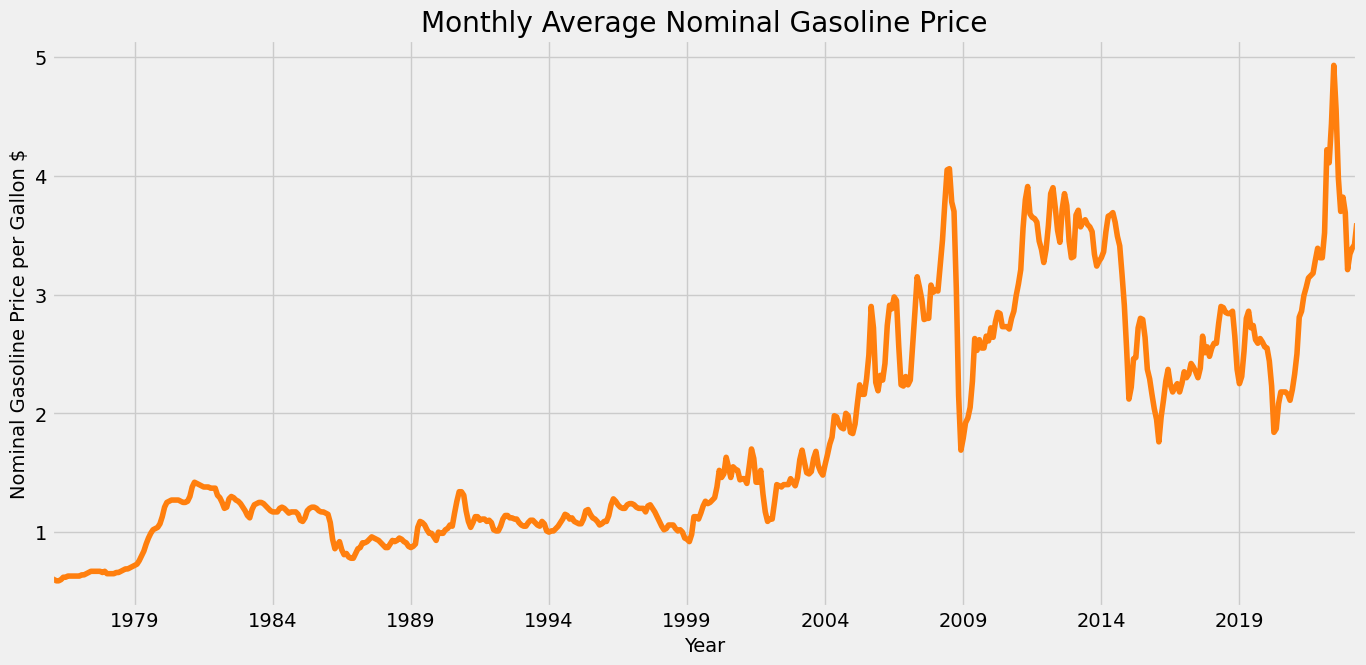

In [16]:
# Plot the Nominal Gas Price
df['Nominal'].plot(figsize = (15,7), color = color_pal[1])
plt.title("Monthly Average Nominal Gasoline Price")
plt.ylabel("Nominal Gasoline Price per Gallon $")
plt.xlabel("Year")
plt.show()

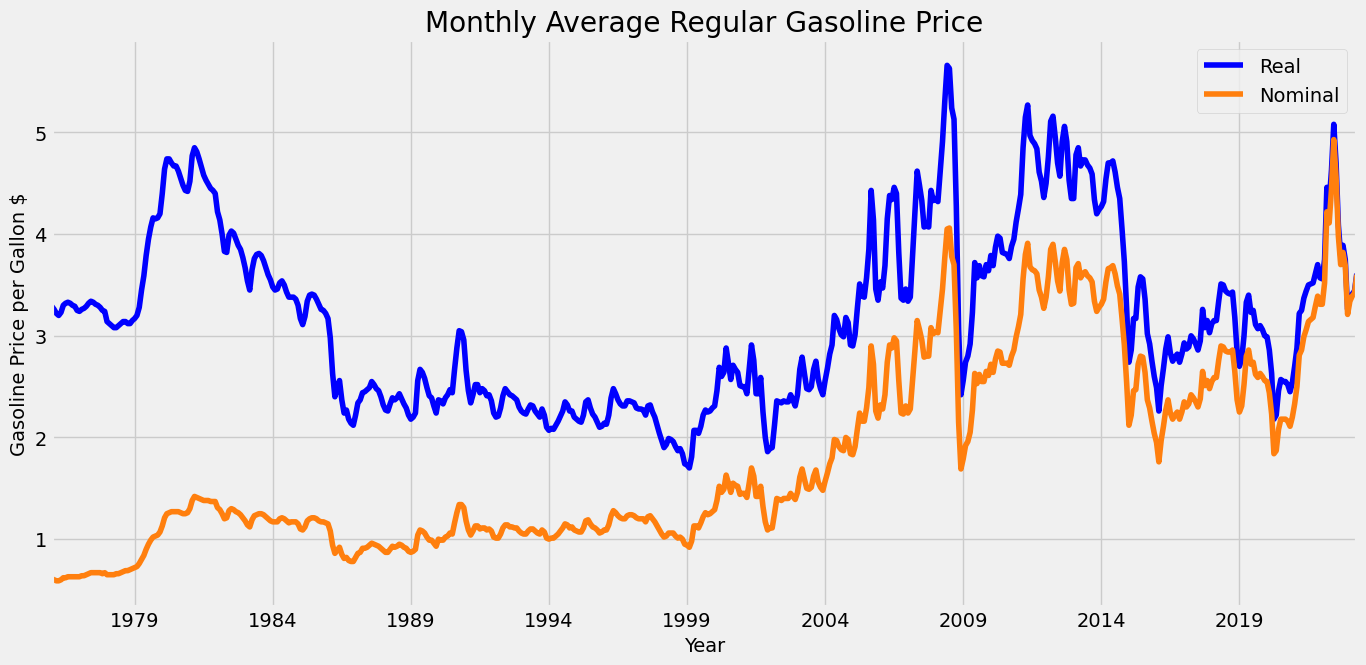

In [17]:
# Plot the Gasoline Real Price alongside its nominal price
fig, ax = plt.subplots(figsize = (15,8))
fig = df['Gas Price'].plot(color = 'b', title = "Monthly Average Regular Gasoline Price")
df['Nominal'].plot(figsize = (15,7), color = color_pal[1], ax = ax)
plt.ylabel("Gasoline Price per Gallon $")
plt.xlabel("Year")
plt.legend(['Real', 'Nominal'])
plt.show()

In [18]:
# index max or last date in our dataframe
df.index.max()

Timestamp('2023-04-01 00:00:00')

In [19]:
# index min or first date in our dataframe
df.index.min()

Timestamp('1976-01-01 00:00:00')

<Figure size 1200x600 with 0 Axes>

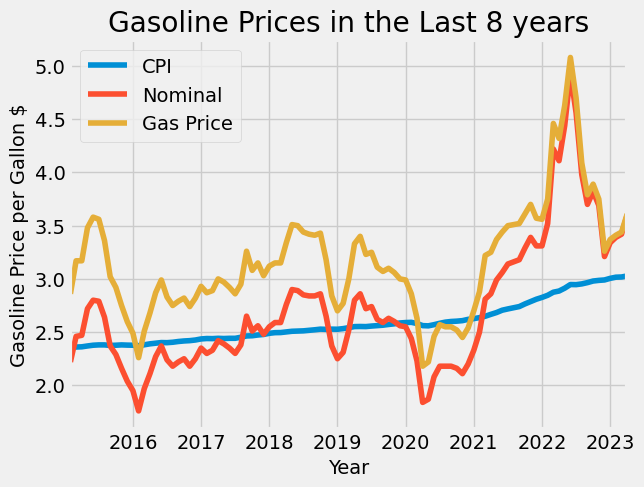

In [20]:
# plot the last 8 years of data
plt.figure(figsize = (12,6))
df.loc[(df.index > '2015-01-01') & (df.index <= '2023-04-01')].plot()
plt.title('Gasoline Prices in the Last 8 years')
plt.ylabel("Gasoline Price per Gallon $")
plt.xlabel("Year")
plt.show()

## Train Test Split

In [21]:
# training data everything before January 1, 2018
train = df.loc[df.index < '01-01-2021']

# testing data everything after January 1, 2018
test = df.loc[df.index >= '01-01-2021']

In [22]:
# dataset shapes
train.shape, test.shape

((540, 3), (28, 3))

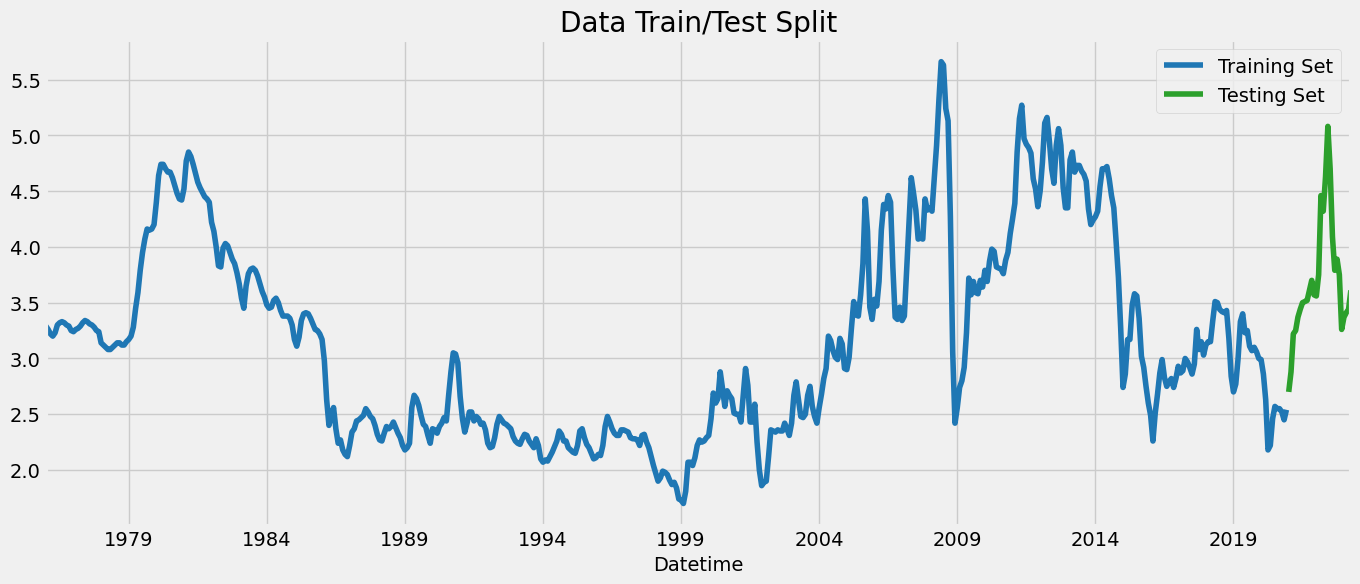

In [23]:
# plot the training and testing data
fig, ax = plt.subplots(figsize = (15,6))
fig = train['Gas Price'].plot(ax = ax, 
                        label = 'Training Set',  
                        title = 'Data Train/Test Split', 
                        color = color_pal[0])

test['Gas Price'].plot(ax = ax, 
                       label = 'Testing Set', 
                       color = color_pal[2])

ax.legend(['Training Set', 'Testing Set'])
plt.show()

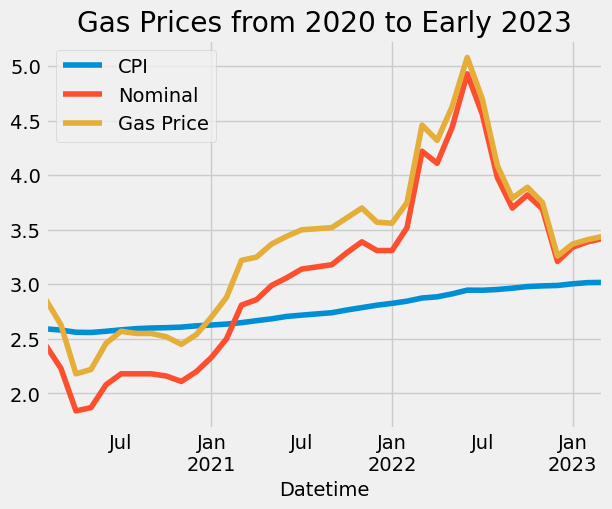

In [24]:
# plot last 2 years of data
df.loc[(df.index > '01-01-2020') & (df.index < '04-01-2023')].plot()
plt.title("Gas Prices from 2020 to Early 2023")
plt.show()

## Time Series Cross Validation

In [25]:
from sklearn.model_selection import TimeSeriesSplit

In [26]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 12*1*3, gap = 0)
df = df.sort_index()

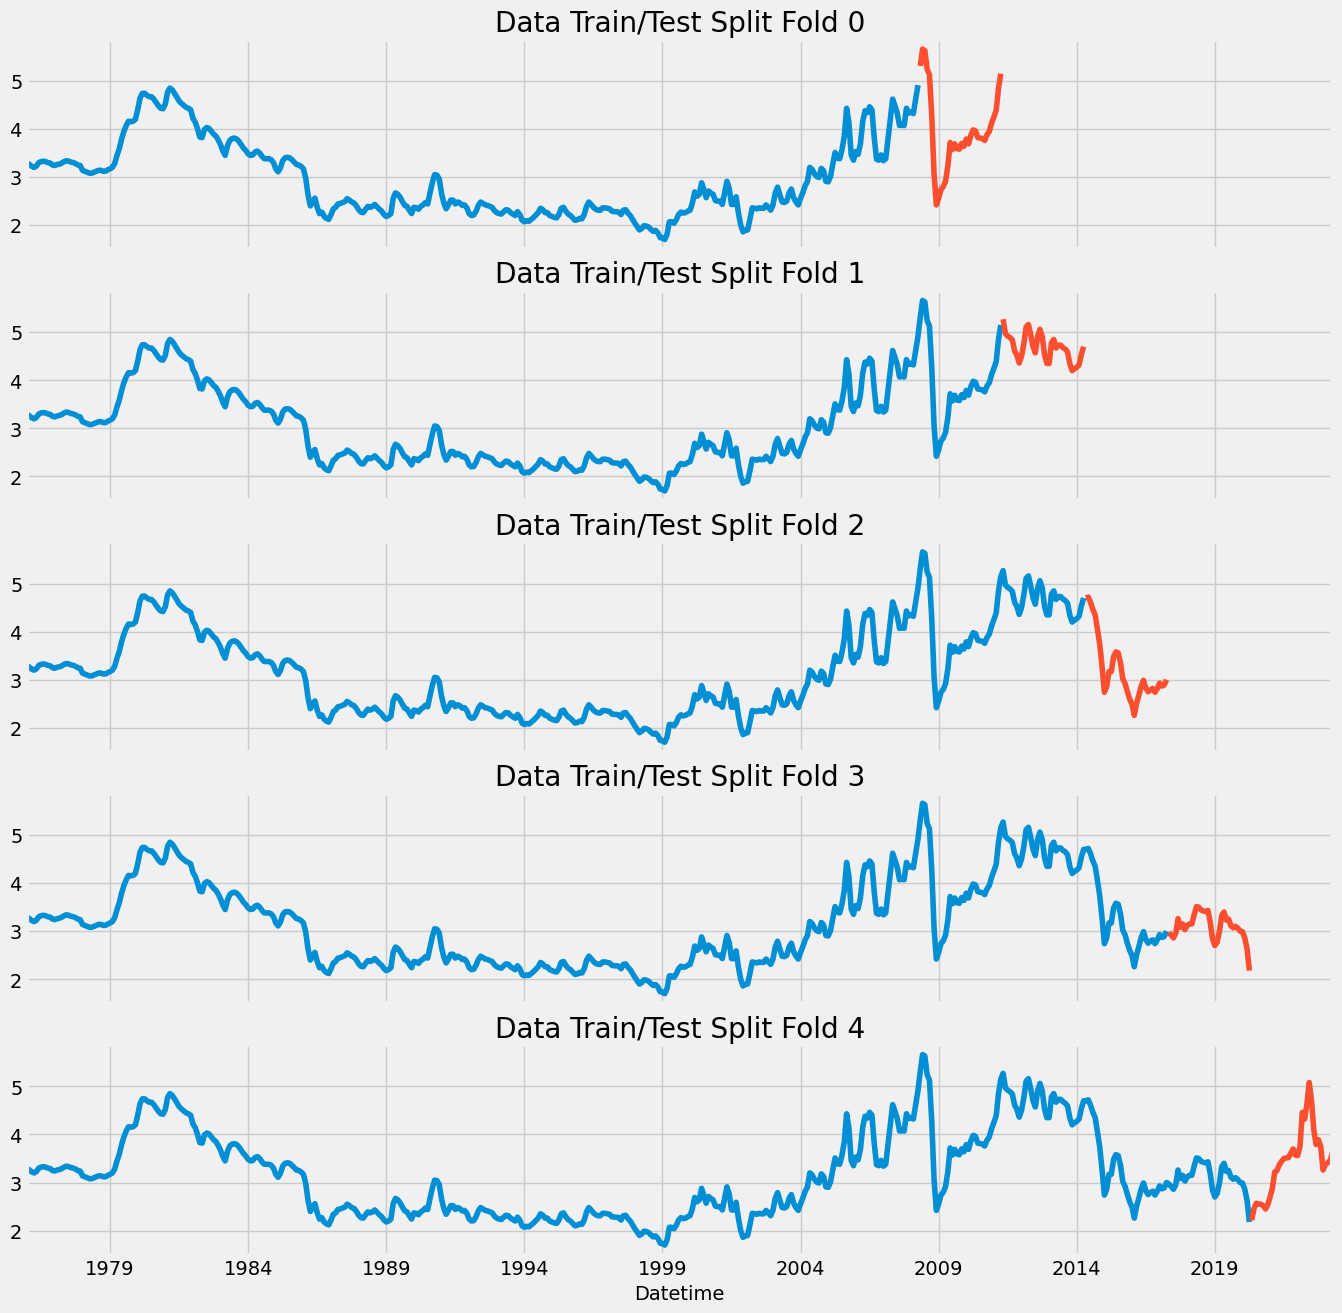

In [27]:
# get indices
fig, axs = plt.subplots(5, 1, figsize = (15,15), sharex = True)
fold = 0 
for train_idx, val_idx in tss.split(df):
    
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Gas Price'].plot(ax = axs[fold], 
                          label = 'Training Set',
                          title = f'Data Train/Test Split Fold {fold}')
    test['Gas Price'].plot(ax = axs[fold], 
                         label = 'Testing Set')
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
                          
    fold += 1

## Feature Engineering

In [28]:
# feature engineering function for time series index

def create_features(df):
    """ 
    create time series features based on time series index
    """ 
    df = df.copy()
    # start from monday as 0 and sunday as a 6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] =  df.index.dayofyear
    return df

#df = create_features(df)

In [29]:
df.tail(24)

,CPI,Nominal,Gas Price
Datetime,,,
2021-05-01,2.684,2.99,3.37
2021-06-01,2.706,3.06,3.44
2021-07-01,2.718,3.14,3.50
2021-08-01,2.729,3.16,3.51
2021-09-01,2.740,3.18,3.52
2021-10-01,2.765,3.29,3.61
2021-11-01,2.787,3.39,3.70
2021-12-01,2.809,3.31,3.57
2022-01-01,2.826,3.31,3.56


In [30]:
# add lagging indicators for future predicitions

def add_lags(df):
    #target_map = df['Gas Price'].to_dict()
    df = df.copy()
    df['lag1'] = df['Gas Price'].shift(1)
    df['lag2'] = df['Gas Price'].shift(2)
    df['lag3'] = df['Gas Price'].shift(3)
    df['lag4'] = df['Gas Price'].shift(4)
    df['lag5'] = df['Gas Price'].shift(5)
    df['lag6'] = df['Gas Price'].shift(6)
    df['lag7'] = df['Gas Price'].shift(8)
    df['lag8'] = df['Gas Price'].shift(10)
    df['lag9'] = df['Gas Price'].shift(11)
    df['lag10'] = df['Gas Price'].shift(13)
    df['lag11'] = df['Gas Price'].shift(15)
    df['lag12'] = df['Gas Price'].shift(16)
    return df
df = add_lags(df)

In [31]:
df.tail()

,CPI,Nominal,Gas Price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
Datetime,,,,,,,,,,,,,,,
2022-12-01,2.990,3.21,3.26,3.75,3.89,3.79,4.09,4.70,5.08,4.32,3.75,3.56,3.70,3.52,3.51
2023-01-01,3.005,3.34,3.37,3.26,3.75,3.89,3.79,4.09,4.70,4.63,4.46,3.75,3.57,3.61,3.52
2023-02-01,3.016,3.39,3.41,3.37,3.26,3.75,3.89,3.79,4.09,5.08,4.32,4.46,3.56,3.70,3.61
2023-03-01,3.018,3.42,3.44,3.41,3.37,3.26,3.75,3.89,3.79,4.70,4.63,4.32,3.75,3.57,3.70
2023-04-01,3.028,3.60,3.61,3.44,3.41,3.37,3.26,3.75,3.89,4.09,5.08,4.63,4.46,3.56,3.57


## XGBoost Model

In [32]:
# import XGBoost
import xgboost as xgb

In [33]:
# train = create_features(train)
# test = create_features(test)

In [34]:
# add lagging indicators for train and testing sets
train = add_lags(train)
test = add_lags(test)

In [35]:
# check the test index
test.index

DatetimeIndex(['2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

In [36]:
# choosing our variables
df.columns

Index(['CPI', 'Nominal', 'Gas Price', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'],
      dtype='object')

In [37]:
# Our Predictors 
Features = ['CPI', 'Nominal','lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6','lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12']

# Our Response Variable
Target = 'Gas Price'

In [38]:
# train test split
X_train = train[Features]
y_train = train[Target]

X_test = test[Features]
y_test = test[Target]

In [39]:
##### n estimators number of trees
# instantiate our model 
boost = xgb.XGBRegressor(n_estimators = 2500, 
                         early_stopping_rounds = 50, 
                         learning_rate = 0.01,
                        max_depth = 4, random_state = 0)
boost.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:2.76770	validation_1-rmse:2.97390
[100]	validation_0-rmse:1.03879	validation_1-rmse:1.12234
[200]	validation_0-rmse:0.40405	validation_1-rmse:0.49835
[300]	validation_0-rmse:0.17543	validation_1-rmse:0.34901
[400]	validation_0-rmse:0.09961	validation_1-rmse:0.32324
[478]	validation_0-rmse:0.07935	validation_1-rmse:0.32429


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

## Feature Importance

In [40]:
# training set columns
X_train.columns

Index(['CPI', 'Nominal', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6',
       'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'],
      dtype='object')

In [41]:
# printing the column importance in our model
boost.feature_importances_

array([0.00399558, 0.01334729, 0.8902878 , 0.00342156, 0.00189928,
       0.00313957, 0.0052947 , 0.00521337, 0.05187559, 0.00422855,
       0.00346263, 0.00319816, 0.00305502, 0.00758101], dtype=float32)

In [42]:
# placing our column importance in a dataframe
fi = pd.DataFrame(data = boost.feature_importances_, index = boost.feature_names_in_,
            columns = ['importance'])

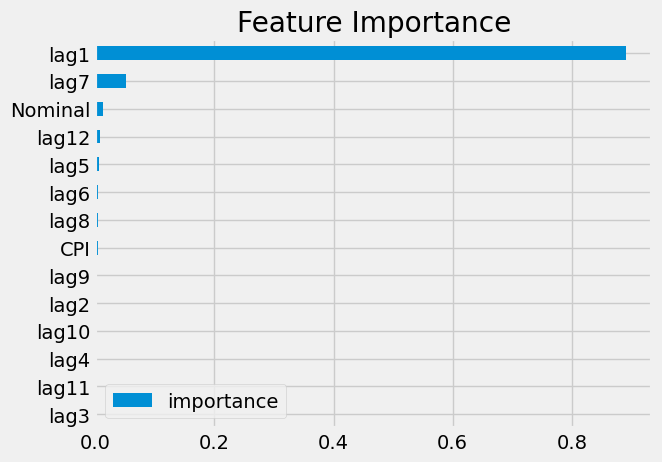

In [43]:
# plot which features were importance in the model as a bundle
fi.sort_values('importance').plot( kind = 'barh', title = 'Feature Importance')
plt.show()

## Forecast on Test

In [44]:
# get test predicitions
test['prediction'] = boost.predict(X_test)

In [45]:
# combining the original dataframe with test predictions
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

In [46]:
# check predictions
df.tail()

,CPI,Nominal,Gas Price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,prediction
Datetime,,,,,,,,,,,,,,,,
2022-12-01,2.990,3.21,3.26,3.75,3.89,3.79,4.09,4.70,5.08,4.32,3.75,3.56,3.70,3.52,3.51,3.801607
2023-01-01,3.005,3.34,3.37,3.26,3.75,3.89,3.79,4.09,4.70,4.63,4.46,3.75,3.57,3.61,3.52,3.017522
2023-02-01,3.016,3.39,3.41,3.37,3.26,3.75,3.89,3.79,4.09,5.08,4.32,4.46,3.56,3.70,3.61,3.375126
2023-03-01,3.018,3.42,3.44,3.41,3.37,3.26,3.75,3.89,3.79,4.70,4.63,4.32,3.75,3.57,3.70,3.444873
2023-04-01,3.028,3.60,3.61,3.44,3.41,3.37,3.26,3.75,3.89,4.09,5.08,4.63,4.46,3.56,3.57,3.541828


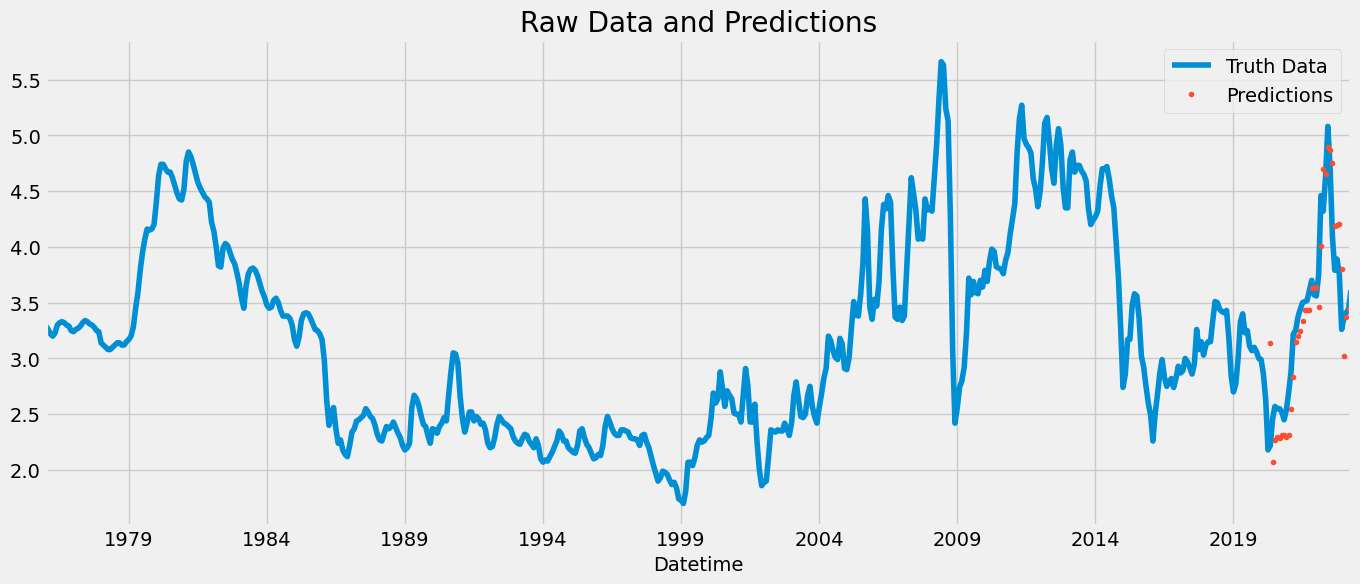

In [47]:
# plot the predicitions vs actual values
ax = df[['Gas Price']].plot(figsize = (15,6))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

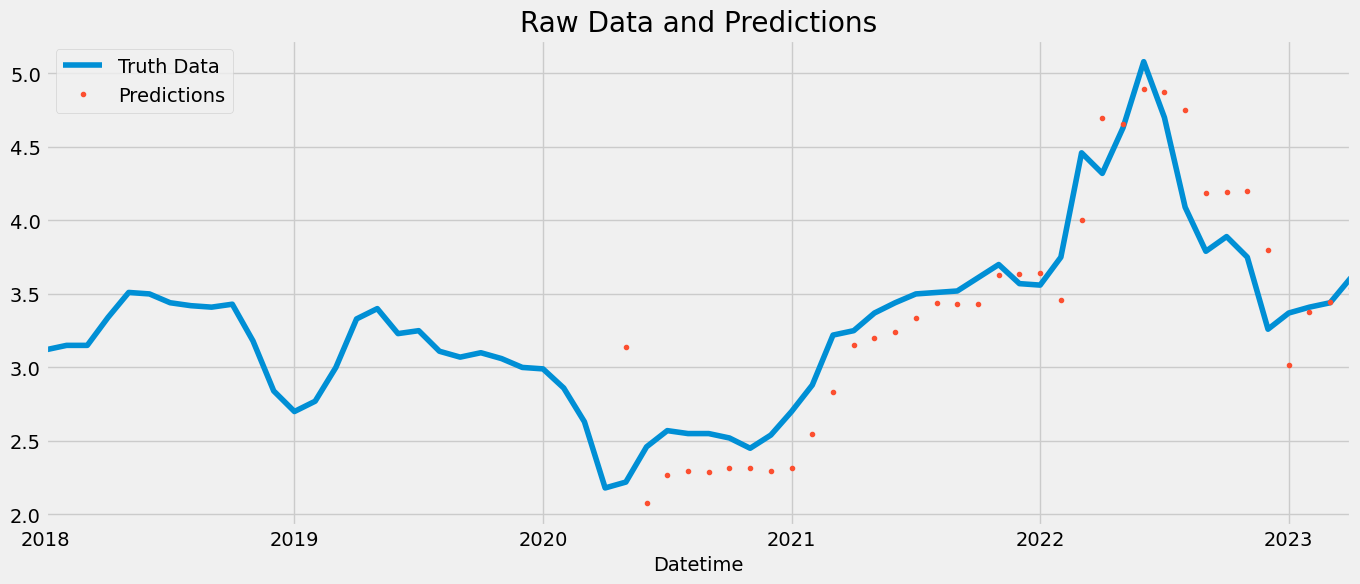

In [48]:
# plot the last 6 years of data along side the predictions
ax = df.loc[df.index >= '01-01-2018']['Gas Price'] \
.plot(figsize = (15,6), title = 'Test Set')
df.loc[df.index >= '01-01-2018']['prediction'] \
.plot(style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

In [49]:
# Root mean squared error for our predictions and actual prices
rmse = mean_squared_error(test['Gas Price'], test['prediction'], squared = False)
print(f'RMSE score on Test set is: {rmse:0.4f}')

RMSE score on Test set is: 0.3215


## Training Using Cross Validation

In [50]:
# 5-fold Cross Validation for Time Series
tss = TimeSeriesSplit(n_splits = 5, test_size = 12*1*3, gap = 0)
df = df.sort_index()


fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    #train = create_features(train)
    #test = create_features(test)
    # add lagging indicators for train and testing sets
    train = add_lags(train)
    test = add_lags(test)
    
    # Our Predictors 
    Features = ['CPI', 'Nominal','lag1', 'lag2', 'lag3', 'lag4', 'lag5'
                ,'lag6','lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12']

    # Our Response Variable
    Target = 'Gas Price'

    X_train = train[Features]
    y_train = train[Target]

    X_test = test[Features]
    y_test = test[Target]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1500,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mean_squared_error(y_test, y_pred, squared = False)
    scores.append(score)

[0]	validation_0-rmse:2.54013	validation_1-rmse:3.49293
[100]	validation_0-rmse:0.95424	validation_1-rmse:1.49346
[200]	validation_0-rmse:0.37130	validation_1-rmse:0.80623
[300]	validation_0-rmse:0.16317	validation_1-rmse:0.62529
[400]	validation_0-rmse:0.09633	validation_1-rmse:0.56877
[500]	validation_0-rmse:0.07492	validation_1-rmse:0.54218
[600]	validation_0-rmse:0.06628	validation_1-rmse:0.53396
[700]	validation_0-rmse:0.06163	validation_1-rmse:0.52856
[800]	validation_0-rmse:0.05749	validation_1-rmse:0.52545
[900]	validation_0-rmse:0.05372	validation_1-rmse:0.52288
[1000]	validation_0-rmse:0.05061	validation_1-rmse:0.52142
[1100]	validation_0-rmse:0.04794	validation_1-rmse:0.52063
[1200]	validation_0-rmse:0.04561	validation_1-rmse:0.52005
[1212]	validation_0-rmse:0.04535	validation_1-rmse:0.52015
[0]	validation_0-rmse:2.63430	validation_1-rmse:4.15206
[100]	validation_0-rmse:0.99297	validation_1-rmse:1.72494
[200]	validation_0-rmse:0.38920	validation_1-rmse:0.69880
[300]	validati

In [51]:
# Cross Validation results
print(f'RMSE mean score across 5-folds: {np.mean(scores):0.4f}')
print(f'5-Fold scores: {scores}')

RMSE mean score across 5-folds: 0.3590
5-Fold scores: [0.5200070468555922, 0.4408833799364168, 0.4038322572766109, 0.15193618898106087, 0.27828856992131157]


## Predicting the Future with XGBoost Regressor

In [52]:
# get all columns
df.columns

Index(['CPI', 'Nominal', 'Gas Price', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12',
       'prediction'],
      dtype='object')

In [53]:
# Retrain on all data 
df = add_lags(df)

# Our Predictors 
Features = ['CPI', 'Nominal','lag1', 'lag2', 'lag3', 'lag4', 'lag5'
                ,'lag6','lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12']

# Our Response Variable
Target = 'Gas Price'

X_all = df[Features]
y_all = df[Target]

reg = xgb.XGBRegressor(n_estimators = 2500, 
                       base_score = 0.5,
                       booster = 'gbtree',
                       objective = 'reg:squarederror',
                       max_depth = 4,
                       learning_rate = 0.01)

reg.fit(X_all, y_all, 
        eval_set = [(X_all,y_all)],
        verbose = 100)

[0]	validation_0-rmse:2.78118
[100]	validation_0-rmse:1.04363
[200]	validation_0-rmse:0.40704
[300]	validation_0-rmse:0.17884
[400]	validation_0-rmse:0.10247
[500]	validation_0-rmse:0.07809
[600]	validation_0-rmse:0.06801
[700]	validation_0-rmse:0.06206
[800]	validation_0-rmse:0.05731
[900]	validation_0-rmse:0.05287
[1000]	validation_0-rmse:0.04872
[1100]	validation_0-rmse:0.04570
[1200]	validation_0-rmse:0.04288
[1300]	validation_0-rmse:0.04023
[1400]	validation_0-rmse:0.03770
[1500]	validation_0-rmse:0.03515
[1600]	validation_0-rmse:0.03286
[1700]	validation_0-rmse:0.03084
[1800]	validation_0-rmse:0.02909
[1900]	validation_0-rmse:0.02726
[2000]	validation_0-rmse:0.02558
[2100]	validation_0-rmse:0.02392
[2200]	validation_0-rmse:0.02257
[2300]	validation_0-rmse:0.02123
[2400]	validation_0-rmse:0.01990
[2499]	validation_0-rmse:0.01887


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Create future dataframe with future dates.

In [54]:
# get the max date in our dataframe
df.index.max()

Timestamp('2023-04-01 00:00:00')

In [55]:
# check the values of our last date
df.tail(1)

,CPI,Nominal,Gas Price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,prediction
Datetime,,,,,,,,,,,,,,,,
2023-04-01,3.028,3.6,3.61,3.44,3.41,3.37,3.26,3.75,3.89,4.09,5.08,4.63,4.46,3.56,3.57,3.541828


In [56]:
# create a future dataframe
# where the dates are seperated by the start of the month 
future = pd.date_range('2023-05-01', '2024-05-01', freq = 'MS')
future

DatetimeIndex(['2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [57]:
# make a future dates into a dataframe
future_df = pd.DataFrame(index = future)
# if the dates are in the future set to True
future_df['isFuture'] = True
# if the dates are not in the future set to false
df['isFuture'] = False
# combine the orginal dataframe with future dates
df_and_future = pd.concat([df,future_df])

In [58]:
# check combined dataframe
df_and_future.tail(10)

,CPI,Nominal,Gas Price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,prediction,isFuture
2023-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [59]:
# add the lags to the combined datasets
df_and_future = add_lags(df_and_future)

In [60]:
# return the dataframe with future dates
future_w_features = df_and_future.query('isFuture').copy()

In [61]:
# print the remaining dataframe
future_w_features 

,CPI,Nominal,Gas Price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,prediction,isFuture
2023-05-01,NaN,NaN,NaN,3.61,3.44,3.41,3.37,3.26,3.75,3.79,4.70,5.08,4.32,3.75,3.56,NaN,True
2023-06-01,NaN,NaN,NaN,NaN,3.61,3.44,3.41,3.37,3.26,3.89,4.09,4.70,4.63,4.46,3.75,NaN,True
2023-07-01,NaN,NaN,NaN,NaN,NaN,3.61,3.44,3.41,3.37,3.75,3.79,4.09,5.08,4.32,4.46,NaN,True
2023-08-01,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.44,3.41,3.26,3.89,3.79,4.70,4.63,4.32,NaN,True
2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.44,3.37,3.75,3.89,4.09,5.08,4.63,NaN,True
2023-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.41,3.26,3.75,3.79,4.70,5.08,NaN,True
2023-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.44,3.37,3.26,3.89,4.09,4.70,NaN,True
2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.41,3.37,3.75,3.79,4.09,NaN,True
2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.44,3.41,3.26,3.89,3.79,NaN,True
2024-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.44,3.37,3.75,3.89,NaN,True


In [62]:
# predict the gas price on the future dates
future_w_features['pred'] = reg.predict(future_w_features[Features])

In [63]:
# check the predicitons
future_w_features

,CPI,Nominal,Gas Price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,prediction,isFuture,pred
2023-05-01,NaN,NaN,NaN,3.61,3.44,3.41,3.37,3.26,3.75,3.79,4.70,5.08,4.32,3.75,3.56,NaN,True,3.804331
2023-06-01,NaN,NaN,NaN,NaN,3.61,3.44,3.41,3.37,3.26,3.89,4.09,4.70,4.63,4.46,3.75,NaN,True,3.397618
2023-07-01,NaN,NaN,NaN,NaN,NaN,3.61,3.44,3.41,3.37,3.75,3.79,4.09,5.08,4.32,4.46,NaN,True,3.215410
2023-08-01,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.44,3.41,3.26,3.89,3.79,4.70,4.63,4.32,NaN,True,3.237188
2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.44,3.37,3.75,3.89,4.09,5.08,4.63,NaN,True,3.053820
2023-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.41,3.26,3.75,3.79,4.70,5.08,NaN,True,3.089891
2023-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.44,3.37,3.26,3.89,4.09,4.70,NaN,True,3.064732
2023-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.41,3.37,3.75,3.79,4.09,NaN,True,3.247691
2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.44,3.41,3.26,3.89,3.79,NaN,True,3.257376
2024-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.61,3.44,3.37,3.75,3.89,NaN,True,3.254144


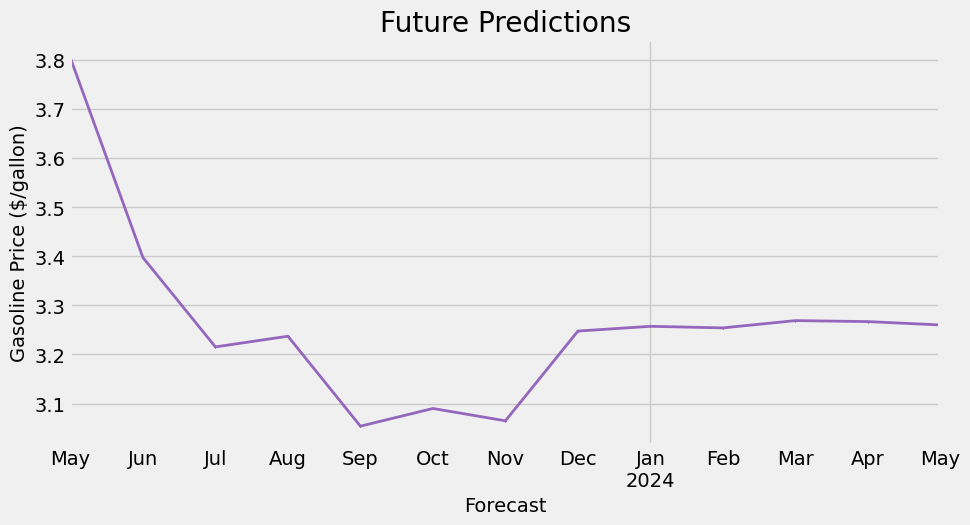

In [64]:
# plot the future dates and predicted prices
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=2,
                               title='Future Predictions',
                              marker = 'x',)
plt.ylabel('Gasoline Price ($/gallon)')
plt.xlabel('Forecast')
plt.show()